# Logistic regression

In this notebook, we want to model a binary dependent variable, that is a variable which has only 2 possible values, such as win/lose. One practical example might be that given a set of tumor predictors (e.g. size) the goal is to calculate the probability if the tumor is malicious. In a more formal way, we are looking for a hypothesis function $h$ which estimates the probability that $y = 1$ on input $x$:

$$
h(x) = P(y=1 | x)
$$

It is desired that the output of this function lies between 0 and 1. In  logistic regression, the logistic/sigmoid function is used:

$$
h(x) = g(b^Tx) = \frac{1}{1 + \exp(-b^Tx)}
$$

$$
b = \left(
    \begin{matrix} 
    b_0 \\
    \vdots \\
    b_m
    \end{matrix}
    \right)
$$

$$
x = \left(
    \begin{matrix} 
    x_0 \\
    \vdots \\
    x_m
    \end{matrix}
    \right)
$$

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

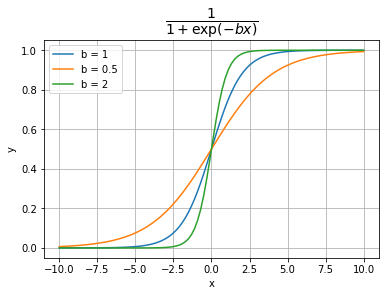

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

points = np.linspace(-10, 10, 100)

fig, ax = plt.subplots()
ax.plot(
    points,
    sigmoid(points),
    label='b = 1'
)
ax.plot(
    points,
    sigmoid(0.5 * points),
    label='b = 0.5'
)
ax.plot(
    points,
    sigmoid(2 * points),
    label='b = 2'
)
ax.set(
    xlabel='x',
    ylabel='y'
)

ax.set_title(r'$\frac{1}{1+\exp(-bx)}$', fontdict=dict(fontsize=20), pad=13)
ax.legend()
ax.grid()

We need to define an error function so that we can find $b$:

$$
J = \frac{1}{m}\sum_{i=1}^{m} \begin{cases} 
-\log(h(x^{(i)})) & \text{if } y^{(i)} = 1 \\
-\log(1-h(x^{(i)})) & \text{if } y^{(i)} = 0
\end{cases}
$$

This can be compressed to:
$$
J = - \frac{1}{m}\sum_{i=1}^{m} \left(y^{(i)}\log(h(x^{(i)})) + (1 - y^{(i)})\log(1-h(x^{(i)})) \right)
$$

Let's plot this function for $y = 1$ and $y = 0$ over $h(x)$:

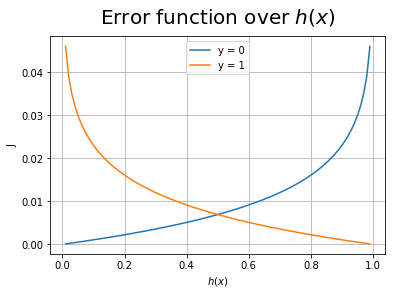

In [3]:
def compute_error_takes_h(y, h):
    m = len(y)
    return -1 / m * (y * np.log(h) + (1 - y) * np.log(1 - h))


number_of_points = 100
h = np.linspace(0.01, 0.99, number_of_points)
y_zeros = np.zeros(number_of_points)
y_ones = np.ones(number_of_points)

fig, ax = plt.subplots()
ax.plot(
    h,
    compute_error_takes_h(y_zeros, h),
    label='y = 0'
)
ax.plot(
    h,
    compute_error_takes_h(y_ones, h),
    label='y = 1'
)

ax.set(
    xlabel=r'$h(x)$',
    ylabel='J'
)

ax.set_title(r'Error function over $h(x)$', fontdict=dict(fontsize=20), pad=13)
ax.legend()
ax.grid()

The derivative of the sigmoid function is:

$$
\frac{\partial g}{\partial x} = g(1 - g)
$$

Which eventually gives us the gradient of the error function:

$$
\frac{\partial J}{\partial b_j} = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)} \left(h(x^{(i)}) - y^{(i)}\right)
$$

Which is the same as the one for the linear regression error function. Instead of copying the code and modifying the error function, let's write a more general function whichs performas gradient descent.

In [4]:
def minimize_using_gradient_descent(error_func, gradient_error_func, b, X, y, alpha=0.01, num_steps=100):
    n, m = X.shape

    error_history = [error_func(b, X, y)]
    for _ in range(num_steps):
        b = b - alpha * gradient_error_func(b, X, y)
        error_history.append(error_func(b, X, y))

    return b, error_history

However, there are more sophisticated hill climbing algorithms than gradient descent. We will use [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) but instead of implementing it on our own, we will use scipy.

In [5]:
# Example of using scipy to minimize a problem. Test for y = 2*x + 1

X = np.c_[np.ones((10, 1)), np.arange(0, 10).reshape((-1, 1))]
y = np.arange(1, 1 + 2 * 10, 2)

def error_func(b, X, y):
    n, m = X.shape
    return 1.0 / (2 * m) * (X.dot(b) - y).T.dot(X.dot(b) - y)

def gradient(b, X, y):
    n, m = X.shape
    return 1/m * X.T.dot(X.dot(b) - y)

initial_b = np.zeros((2, 1))
optimized_b = minimize(error_func, initial_b, args=(X,y), method='BFGS', jac=gradient).x
expected_b = [1, 2]

assert np.allclose(optimized_b, expected_b)